In [1]:
#PROJECT PHASE 2
#GROUP 1 (AMAZON FASHION)

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Data Exploration & Preprocessing

Loaded 5000 reviews.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         5000 non-null   float64
 1   verified        5000 non-null   bool   
 2   reviewTime      5000 non-null   object 
 3   reviewerID      5000 non-null   object 
 4   asin            5000 non-null   object 
 5   reviewerName    5000 non-null   object 
 6   reviewText      4998 non-null   object 
 7   summary         4999 non-null   object 
 8   unixReviewTime  5000 non-null   int64  
 9   vote            592 non-null    object 
 10  style           3866 non-null   object 
 11  image           81 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 434.7+ KB
None
   overall  verified   reviewTime      reviewerID        asin  reviewerName  \
0      5.0      True  10 20, 2014  A1D4G1SNUZWQOT  7106116521         Tracy   
1     

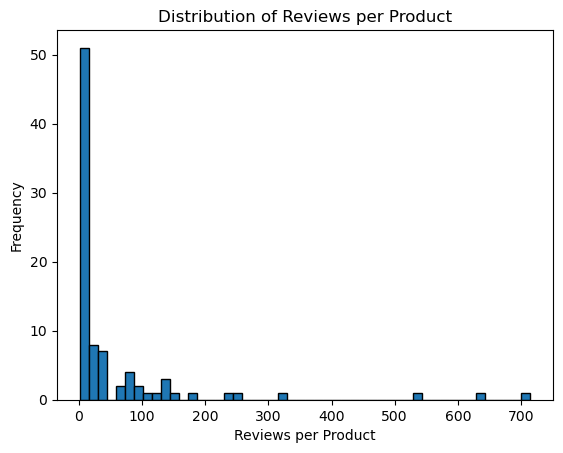

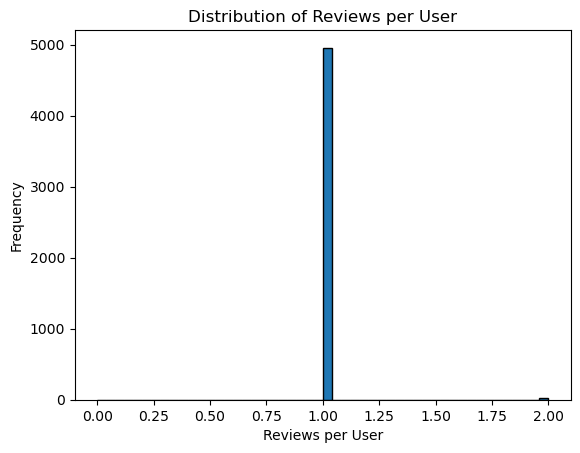

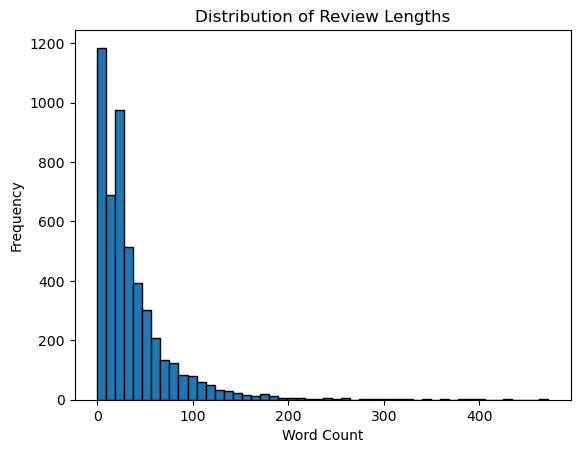

Initial dataset size: 5000
Duplicate reviews found: 0
Dataset size after removing duplicates: 5000
Sample labeled data:
                                          reviewText sentiment
0                              exactly what i needed  Positive
1  i agree with the other review the opening is t...  Negative
2  love these i am going to order another pack to...  Positive
3                                too tiny an opening  Negative
4                                               okay   Neutral
5                              exactly what i wanted  Positive
6  these little plastic backs work great  no more...  Positive
7  mother  in  law wanted it as a present for her...   Neutral
8  item is of good quality looks great too but it...   Neutral
9  i had used my last elcheapo fake leather cigar...   Neutral


In [3]:
# loading a subset of the full dataset
def load_json_lines(path, limit=5000):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= limit: break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON at line {i}: {e}")
    return pd.DataFrame(data)

# loading full Amazon Fashion dataset subset
file_path = "AMAZON_FASHION.json"
df = load_json_lines(file_path, limit=5000)
print(f"Loaded {len(df)} reviews.")

# basic exploration
print(df.info())
print(df.head())
print(f"Total unique products: {df['asin'].nunique()}")
print(f"Total unique users: {df['reviewerID'].nunique()}")
print(f"Average rating: {df['overall'].mean():.2f}")
print(df['overall'].value_counts(normalize=True) * 100)

# review Length Analysis
df["review_length"] = df["reviewText"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
print(f"Average review length: {df['review_length'].mean():.2f}")
print(f"Max: {df['review_length'].max()} | Min: {df['review_length'].min()}")

# distribution visualizations
# reviews per product
reviews_per_product = df.groupby("asin")["reviewText"].count()
plt.hist(reviews_per_product, bins=50, edgecolor='black')
plt.title("Distribution of Reviews per Product")
plt.xlabel("Reviews per Product")
plt.ylabel("Frequency")
plt.show()

# reviews per user
reviews_per_user = df.groupby("reviewerID")["reviewText"].count()
plt.hist(reviews_per_user, bins=50, edgecolor='black')
plt.title("Distribution of Reviews per User")
plt.xlabel("Reviews per User")
plt.ylabel("Frequency")
plt.show()

# review length distribution
plt.hist(df["review_length"], bins=50, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# handling duplicates
print(f"Initial dataset size: {len(df)}")
duplicates = df[df.duplicated(subset=["reviewText", "reviewerID", "asin"], keep=False)]
print(f"Duplicate reviews found: {len(duplicates)}")
df = df.drop_duplicates(subset=["reviewText", "reviewerID", "asin"], keep='first')
print(f"Dataset size after removing duplicates: {len(df)}")

# removing empty reviews
df = df[df["reviewText"].notna() & (df["reviewText"] != "")]

# label sentiment
def label_sentiment(score):
    if score >= 4:
        return "Positive"
    elif score == 3:
        return "Neutral"
    else:
        return "Negative"

df["sentiment"] = df["overall"].apply(label_sentiment)
df["reviewText"] = df["reviewText"].str.lower()
df["reviewText"] = df["reviewText"].str.replace(r"[^\w\s]", "", regex=True)

# keeping relevant columns
df = df[["reviewText", "sentiment"]]

# final overview
print("Sample labeled data:")
print(df.head(10))

# Text Representation & Data Splitting

sentiment
Positive    3814
Negative     658
Neutral      526
Name: count, dtype: int64


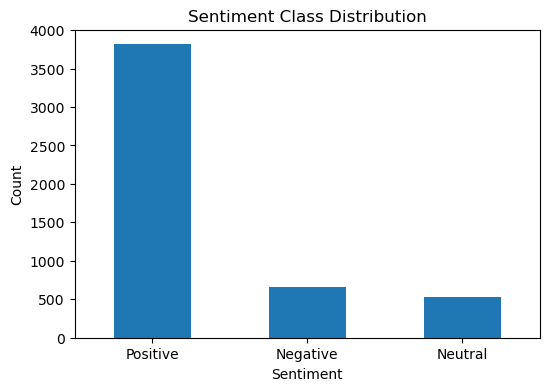

In [4]:
# Check class distribution
print(df['sentiment'].value_counts())

# Plot the distribution of sentiments
plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [5]:
# Text Representation
# Apply TF-IDF Vectorizer to 'reviewText' column
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["reviewText"])

# Original labels (non-encoded)
y_orig = df['sentiment']

In [6]:
# # Another vectorizer if you want to experiment

# from sklearn.feature_extraction.text import CountVectorizer

# # Apply Count Vectorizer
# vectorizer = CountVectorizer(max_features=5000)
# X = vectorizer.fit_transform(df["reviewText"])  # Convert text data into features

# # Original labels (non-encoded)
# y_orig = df['sentiment']

In [7]:
# Encode labels for models like XGBoost, MLP, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y_orig)

# Split the dataset into features (X) and labels (y) first, and make sure we are stratifying based on the labels
# 70% Training and 30% Testing with encoded labels for models that require encoding
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

# 70% Training and 30% Testing with original labels for models that don't require encoding
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y_orig, test_size=0.3, stratify=y_orig, random_state=42)

# There is (choose which one to use based on the model):
# 1. Encoded splits: X_train_enc, X_test_enc, y_train_enc, y_test_enc
# 2. Original splits: X_train_orig, X_test_orig, y_train_orig, y_test_orig

In [8]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE only on the training set to balance the classes
smote = SMOTE(random_state=42)

# Apply SMOTE on the encoded labels training set
X_train_enc_smote, y_train_enc_smote = smote.fit_resample(X_train_enc, y_train_enc)

# Apply SMOTE on the original labels training set
X_train_orig_smote, y_train_orig_smote = smote.fit_resample(X_train_orig, y_train_orig)

# Print class distribution after SMOTE
smote_counts = pd.Series(y_train_enc_smote).value_counts().sort_index()
smote_labels = le.inverse_transform(smote_counts.index)

print("\nClass distribution after SMOTE:")
for label, count in zip(smote_labels, smote_counts):
    print(f"{label}: {count}")
    
# print total number of samples after SMOTE
print(f"Total samples after SMOTE: {X_train_enc_smote.shape[0]}")


Class distribution after SMOTE:
Negative: 2669
Neutral: 2669
Positive: 2669
Total samples after SMOTE: 8007


# Gradient Boost (extra model, can remove later)

In [9]:
# Gradient Boosting Classifier using sklearn WITHOUT SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Train on original encoded training data
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_enc, y_train_enc)
y_pred = gb_model.predict(X_test_enc)

# Evaluation using original labels
print("Gradient Boosting With Sklearn (Original Data) Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test_enc, y_pred))

print("\nGradient Boosting Classifier Accuracy:")
print(gb_model.score(X_test_enc, y_test_enc))

Gradient Boosting With Sklearn (Original Data) Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.30      0.41       197
     Neutral       0.44      0.07      0.12       158
    Positive       0.81      0.97      0.88      1145

    accuracy                           0.79      1500
   macro avg       0.63      0.45      0.47      1500
weighted avg       0.75      0.79      0.74      1500

Confusion Matrix:
[[  59    4  134]
 [  15   11  132]
 [  19   10 1116]]

Gradient Boosting Classifier Accuracy:
0.7906666666666666


In [10]:
# Train with SMOTE-balanced training data
gb_model_smote = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model_smote.fit(X_train_enc_smote, y_train_enc_smote)
y_pred_smote = gb_model_smote.predict(X_test_enc)

# Evaluation using original labels
print("\nGradient Boosting With Sklearn (With SMOTE) Classification Report:")
print(classification_report(y_test_enc, y_pred_smote, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test_enc, y_pred_smote))

print("\nGradient Boosting Classifier Accuracy (With SMOTE):")
print(gb_model_smote.score(X_test_enc, y_test_enc))


Gradient Boosting With Sklearn (With SMOTE) Classification Report:
              precision    recall  f1-score   support

    Negative       0.54      0.63      0.58       197
     Neutral       0.32      0.35      0.33       158
    Positive       0.90      0.86      0.88      1145

    accuracy                           0.78      1500
   macro avg       0.59      0.61      0.60      1500
weighted avg       0.79      0.78      0.78      1500

Confusion Matrix:
[[124  28  45]
 [ 36  55  67]
 [ 68  91 986]]

Gradient Boosting Classifier Accuracy (With SMOTE):
0.7766666666666666


In [24]:
#!pip install xgboost

In [13]:
# Gradient Boosting Classifier using XGBoost WITHOUT SMOTE
from xgboost import XGBClassifier

# Fit the model on original data
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_orig, y_train_enc)  # Train with encoded labels
y_pred = xgb_model.predict(X_test_orig)  # Predict using the test set with original labels

# Inverse transform the predictions back to original labels
y_pred_labels = le.inverse_transform(y_pred)

# Evaluation
print("XGBoost Classification Report (Without SMOTE):")
print(classification_report(y_test_orig, y_pred_labels))

print("Confusion Matrix (Without SMOTE):")
print(confusion_matrix(y_test_orig, y_pred_labels))

print("\nXGBoost Classifier Accuracy (Without SMOTE):")
print(xgb_model.score(X_test_orig, y_test_enc))  # Use encoded labels for score calculation

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:20:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report (Without SMOTE):
              precision    recall  f1-score   support

    Negative       0.67      0.35      0.46       197
     Neutral       0.38      0.06      0.10       158
    Positive       0.81      0.98      0.89      1145

    accuracy                           0.80      1500
   macro avg       0.62      0.46      0.48      1500
weighted avg       0.75      0.80      0.75      1500

Confusion Matrix (Without SMOTE):
[[  69    7  121]
 [  14    9  135]
 [  20    8 1117]]

XGBoost Classifier Accuracy (Without SMOTE):
0.7966666666666666


In [14]:
# Fit the model on SMOTE balanced data
xgb_model_smote = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model_smote.fit(X_train_enc_smote, y_train_enc_smote)  # Train with SMOTE balanced data
y_pred_smote = xgb_model_smote.predict(X_test_orig)  # Predict using the original test data (no SMOTE)

# Inverse transform the predictions back to original labels
y_pred_smote_labels = le.inverse_transform(y_pred_smote)

# Evaluation after SMOTE
print("XGBoost Classification Report (With SMOTE):")
print(classification_report(y_test_orig, y_pred_smote_labels))

print("Confusion Matrix (With SMOTE):")
print(confusion_matrix(y_test_orig, y_pred_smote_labels))

print("\nXGBoost Classifier Accuracy (With SMOTE):")
print(xgb_model_smote.score(X_test_orig, y_test_enc))  # Use encoded labels for score calculation

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report (With SMOTE):
              precision    recall  f1-score   support

    Negative       0.52      0.54      0.53       197
     Neutral       0.28      0.26      0.27       158
    Positive       0.87      0.88      0.87      1145

    accuracy                           0.77      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.76      0.77      0.76      1500

Confusion Matrix (With SMOTE):
[[ 106   23   68]
 [  38   41   79]
 [  61   82 1002]]

XGBoost Classifier Accuracy (With SMOTE):
0.766


# Model 1 (Logistic Regression Model Building and Hyperparameter Tuning)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
# Initialize logistic regression
lr = LogisticRegression(random_state=42, max_iter=1000)

# Fit to training data
lr.fit(X_train_orig, y_train_orig)

# Predict on test data
y_pred_lr = lr.predict(X_test_orig)

# Evaluate
print("Accuracy:", accuracy_score(y_test_orig, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred_lr))

Accuracy: 0.812

Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.38      0.51       197
     Neutral       0.50      0.08      0.14       158
    Positive       0.82      0.99      0.90      1145

    accuracy                           0.81      1500
   macro avg       0.69      0.48      0.51      1500
weighted avg       0.78      0.81      0.77      1500



In [18]:
# Hyperparameter Tuning

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Grid Search
grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_orig, y_train_orig)

print("Best Parameters:", grid.best_params_)

# Predict with best model
y_pred_best = grid.best_estimator_.predict(X_test_orig)

# Final evaluation
print("\nBest Model Accuracy:", accuracy_score(y_test_orig, y_pred_best))
print("\nBest Model Classification Report:\n", classification_report(y_test_orig, y_pred_best))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Accuracy: 0.8126666666666666

Best Model Classification Report:
               precision    recall  f1-score   support

    Negative       0.65      0.49      0.56       197
     Neutral       0.42      0.20      0.27       158
    Positive       0.85      0.95      0.90      1145

    accuracy                           0.81      1500
   macro avg       0.64      0.55      0.58      1500
weighted avg       0.78      0.81      0.79      1500



# Visualization

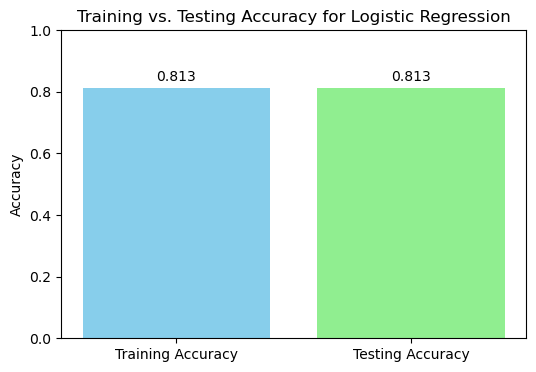

In [22]:
# Training vs. Testing Accuracy

import matplotlib.pyplot as plt

# Results you have
train_accuracy = 0.813  # After tuning 
test_accuracy = 0.8127  # Slight rounding

# Creating a bar chart
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy, test_accuracy], color=['skyblue', 'lightgreen'])

# Add text labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylim(0, 1)
ax.set_title('Training vs. Testing Accuracy for Logistic Regression')
ax.set_ylabel('Accuracy')
plt.show()

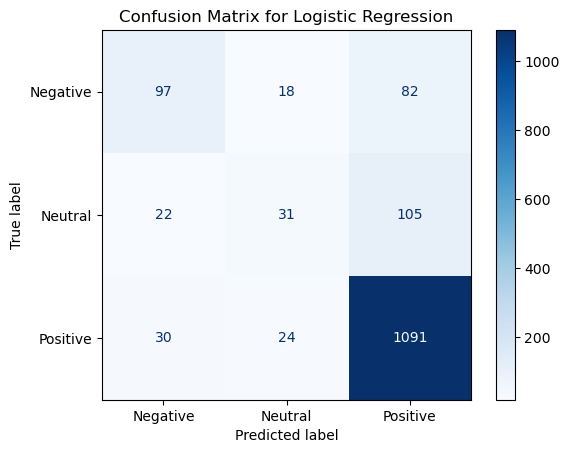

In [20]:
# Visualization

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test_orig, y_pred_best)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

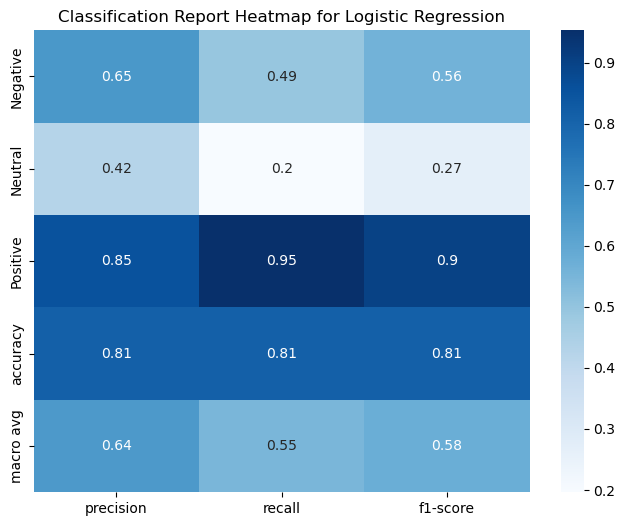

In [21]:
import seaborn as sns

# Generate classification report
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test_orig, y_pred_best, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title('Classification Report Heatmap for Logistic Regression')
plt.show()

# Model 2